## Linear Regression
### Name: Bryant McArthur
### Class: Math 403
### Section: 001 or 002
### Date: November 1, 2022

In [2]:
import numpy as np
from scipy import linalg as la
import pandas as pd
import time
import statsmodels.api as sm
from sklearn import linear_model
from itertools import combinations
from matplotlib import pyplot as plt

## Problem 1
Write a function that takes as input $X$ and **y** as defined on page 1. Call this function **ols**. This function should return the least squares estimator for $\beta$ as a numpy array.

In [3]:
def ols(X, y):
    """
    Solves for the least squares estimator.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpyarray
    """
    # Add column of ones before you solve
    X = np.column_stack((np.ones(len(X)),X))
    beta = la.inv(X.T@X)@X.T@y
    
    return beta

## Problem 2
Find the least squares estimator for $\beta$ using this random data. 
Produce a plot showing the random data and the line of best fit determined by the least squares estimator for $\beta$. 
Your plot should include a title, axis labels, and a legend. 

In [4]:
# Set up
n = 100
X = np.arange(100)
eps = np.random.uniform(-10,10, size=(100,))
y = .3*X + 3 + eps

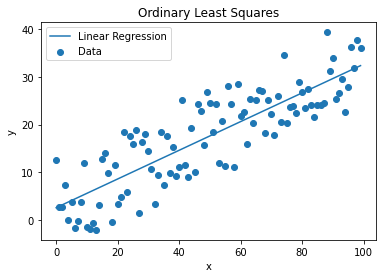

In [5]:
beta = ols(X[0:],y)

# Plot it
plt.scatter(X,y, label="Data")
plt.plot(X,beta[1]*X + beta[0], label="Linear Regression")
plt.title("Ordinary Least Squares")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Problem 3
Write a function that finds the least squares estimator for rank-deficient models using the SVD. 
The function should still take $X$ and **y** as inputs. Call the function **svd_ols** and return the least squares estimator for $\beta$ as a numpy array.

In [144]:
def svd_ols(X, y):
    """
    Solves for the least squares estimator using the SVD.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpy array
    """
    # Add column of ones here, but I don't know why we can't just do that before we pass it in
    n,d = X.shape
    b = np.ones((n,1))
    X = np.hstack((b,X))
    
    # Do the SVD
    U,s,Vh = np.linalg.svd(X, full_matrices = False)
    
    # Now solve
    beta = Vh.T @ la.inv(np.diag(s)) @ U.T @ y
    
    return beta

## Problem 4
Use your function **svd_ols** to find the least squares estimator for a cubic polynomial. 
Create a plot that shows a scatter plot of the data and a curve using the least squares estimator. 
Your plot should include a title, axis labels, and a legend.

In [148]:
# Set up
x = np.linspace(-4,2,500)
y = x**3 + 3*x**2 - x - 3.5
eps = np.random.normal(0, 3, len(y))
y += eps

col1 = x**3
col2 = x**2
col3 = x

X = np.column_stack((col1,col2,col3))

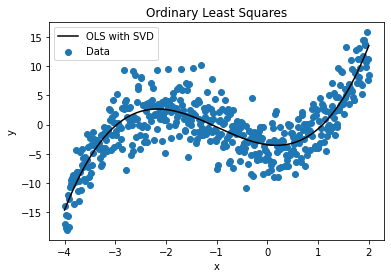

In [149]:
beta = svd_ols(X,y)

X = np.column_stack((np.ones(len(y)),X))
# Plot it
plt.scatter(x,y, label="Data")
plt.plot(x, X@beta, 'k-', label="OLS with SVD")
plt.title("Ordinary Least Squares")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Problem 5
The file **realestate.csv** contains transaction data from 2012-2013. 
It has columns for transaction data, house age, distance to nearest MRT station, number of convenience stores, latitude, longitude, and house price of unit area.
Each row in the array is a separate measurement.

Find the combination of variables that builds the model with the best $R^2$ value when predicting **house price of unit area**. Use statsmodels to build each model and calculate $R^2$. Use **statsmodels** to build each model and calculate $R^2$. Using the same combination of variables, time the methods **ols**, **svd_ols**, and **statsmodels** . Return a list with the first element being a tuple of times for each method and the second element being the best $R^2$ value from the first part of the problem.

In [150]:
def problem5():
    """
    Find the best R2 value using statsmodels.
    Then time ols, svd_ols, and statsmodlels.
    Returns:
        list(): a tuple of times and the best R2 value
    """
    # Read in data
    df = pd.read_csv("realestate.csv")
    df = df.set_index("No")
    y = df['Y house price of unit area']
    data = df.loc[:, df.columns != 'Y house price of unit area']
    
    # Time myself
    start = time.time()
    
    columns = data.columns
    
    # Iterate through the combinations of features and save the best
    best = 0
    for num_features in range(2, len(data.columns)+1):
        features = [list(feature_set) for feature_set in list(combinations(data.columns, r=num_features))]
        for feature_set in features:
            X = data[feature_set]
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            coef = model.rsquared
            if coef > best:
                best = coef
                columns = feature_set
                
    naive_time = time.time() - start
    
    X = data[columns]
    
    # Time ols
    start = time.time()
    ols(X,y)
    ols_time = time.time() - start
    
    # Time svd_ols
    start = time.time()
    svd_ols(X,y)
    svd_time = time.time() - start
    
    return (naive_time, ols_time, svd_time), best

In [151]:
problem5()

((0.3427567481994629, 0.0, 0.0), 0.5823704472722955)

## Problem 6
Use the file **realestate.csv** and the Python Example on page 4 as a template for constructing **y** and $X$ and calculating model AIC and BIC. 
For the dependent variable, use **house price of unit area**. 
For the independent variables, use **distance to the nearest MRT station**, **number of convenience stores**, **latitude**, and **longitude**.

Find the model that has the lowest AIC and the model that has the lowest BIC. Are they the same model? Print the features of the model with the lowest AIC as a list.

In [152]:
def prob6():
    """problem 6"""
    # Load in data
    df = pd.read_csv('realestate.csv')
    df = df.set_index("No")
    y = df['Y house price of unit area']
    data = df[['X3 distance to the nearest MRT station',
              'X4 number of convenience stores',
              'X5 latitude',
              'X6 longitude']]
    
    # Set up what I want to save
    aic_cols = data.columns
    bic_cols = data.columns
    best_aic = float('inf')
    best_bic = float('inf')
    best_rcoef = 0
    
    # Iterate through feature combinations
    for num_features in range(2, len(data.columns)+1):
        features = [list(feature_set) for feature_set in list(combinations(data.columns, r=num_features))]
        for feature_set in features:
            X = data[feature_set]
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                aic_cols = feature_set
                
            bic = model.bic
            if bic < best_bic:
                best_bic = bic
                bic_cols = feature_set
                
            coef = model.rsquared
            if coef > best_rcoef:
                best_rcoef = coef
    
    return (best_aic, best_bic), (aic_cols, bic_cols), best_rcoef

In [153]:
x,y,z = prob6()
print("Best AIC", x[0])
print("AIC features", y[0])
print("Best BIC", x[1])
print("BIC features", y[1])
print("R^2 value", z)

Best AIC 3038.536259321838
AIC features ['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude']
Best BIC 3054.639723217139
BIC features ['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude']
R^2 value 0.5211770996011518


## Problem 7
Use Ridge and Lasso Regression to model **house price of unit area** from the file **realestate.csv**.
Before fitting each model, run a GridSearch on $\alpha$ to find the optimal value.
Then use the optimal $\alpha$ to fit the model.
Once you have fit the model, you can use the **score** method to get $R^2$. 
Print $R^2$ for each model as a tuple. 
How do these models compare to the models in problem 6?

In [154]:
def prob7():
    """Problem 7"""
    # Load in data
    df = pd.read_csv('realestate.csv')
    y = df['Y house price of unit area']
    X = df[[
        'X1 transaction date',
        'X2 house age',
        'X3 distance to the nearest MRT station',
        'X4 number of convenience stores',
        'X5 latitude',
        'X6 longitude'
    ]]
    
    # L2
    reg = linear_model.RidgeCV(alphas=np.logspace(-6,6,13))
    reg.fit(X,y)
    
    # L1
    lasso = linear_model.LassoCV(alphas=np.logspace(-6,6,13))
    lasso.fit(X,y)

    return (reg.alpha_, reg.score(X,y)), (lasso.alpha_, lasso.score(X,y))

In [155]:
x,y = prob7()
print("Ridge alpha and score: ", x)
print("Lasso alpha and score: ", y)

Ridge alpha and score:  (0.001, 0.5823545296945134)
Lasso alpha and score:  (0.001, 0.5822617746792766)


They are very similar R^2 scores but are .06 greater than from problem 6. This is a nice increase in R^2 value.